# Analyzing Political Bias in ConceptNet Numberbatch and GloVe 840B Embeddings

By Elias Mann and Mark Brubaker

In this notebook, we will analyze the political bias of two word embeddings: ConceptNet Numberbatch and GloVe 840B. This is a relevent topic as tthe popular word embeddings are widely used in large language models and other NLP tasks. As of writing this notebook (February 2023) the use large language models (LLMs) has just reached the mainstream. With the OpenAI's release of ChatGPT and its viral reception, people are using large languaeg models more than ever. Bing has incorporated a version of Chat GPT into their search engine and a race to deploy LLMs at scale as begun, with competitors like Microsoft, Google, Facebook and Amazon all working on their own versions. <br>
While these LLM's

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, MaxPooling1D, Conv1D, Input, Dense, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  0
Num CPUs Available:  1
Tensorflow version: 2.9.1
Keras version: 2.9.0
No GPU found


In [9]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [10]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TITLE_LEN = 32 # maximum and minimum number of words
NUM_CLASSES = 2


labeled_content = pd.read_csv('data/labeled_headlines.csv')
labeled_content = labeled_content[labeled_content['score'] != 0]

#concatenate title and first 256 words in content in one column
# labeled_content['title_content'] = labeled_content['title'].astype(str) + ' ' + labeled_content['content'].astype(str).str[:256]


X = labeled_content['title'].astype(str).values
y = labeled_content['score'].values
                                #.astype('float32')

tokenizer = Tokenizer(
                    num_words=NUM_TOP_WORDS,
                    filters = '—!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t…\'‘’'
                     )

tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))

X = pad_sequences(sequences, maxlen=MAX_TITLE_LEN)
y = np.where(y == -1, 0, 1)

# y = keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

print(f"Found {len(word_index):,} unique tokens. Distilled to {top_words:,} top words.")

Found 12,013 unique tokens. Distilled to 12,013 top words.


In [11]:
# now fill in the matrix, using the ordering from the
# keras word tokenizer from before
def generate_embed_matrix(embed):
    EMBED_SIZE = embed.shape[1]
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

    for word, i in word_index.items():

        try:
            embedding_vector = embed.loc[word]
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1
        except:
            #print(word)
            pass

    print(f"Embedding Shape: {embedding_matrix.shape}")
    print(f"Total words found: {found_words:,}")
    print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")
    
    return embedding_matrix

In [12]:
def generate_model(embed_matrix):
    EMBED_SIZE = embed_matrix.shape[1]
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBED_SIZE,
                                weights=[embed_matrix],# here is the embedding getting saved
                                input_length=MAX_TITLE_LEN,
                                trainable=False)

    inputs = Input(shape=(MAX_TITLE_LEN,), dtype=tf.int32)
    embedding = embedding_layer(inputs)

    # Add a 1D Convolutional layer
    x = Conv1D(filters=128, kernel_size=5, activation='relu',
                                          kernel_initializer='he_uniform')(embedding)
    x = MaxPooling1D(pool_size=2)(x) # Add a Max Pooling layer

    # x = Dropout(0.20)(x)
    # x = Conv1D(128, 3, activation='relu',
    #            kernel_initializer='he_uniform')(x)

    # # new size is 195
    # x = MaxPooling1D(2)(x) # after max pool, size is 195/5 = 39
    # x = Dropout(0.25)(x)
    # x = Conv1D(128, 3, activation='relu',
    #            kernel_initializer='he_uniform')(x)

    #x = MaxPooling1D(2)(x) # this is the size to globally flatten 

    # Flatten the output of\ the Max Pooling layer
    x = Flatten()(x)
    x = Dropout(0.10)(x)
    x = Dense(units=64, activation='sigmoid')(x)
    x = Dense(units=32, activation='sigmoid')(x)

    # Add a Dense output layer with a single neuron and a sigmoid activation function
    outputs = Dense(units=1, activation='linear')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [13]:
# %%time
# numberbatch_embeddings = load_embeddings("embeddings/numberbatch-en-17.04b.txt")
# numberbatch_embeddings.shape

In [14]:
# numberbatch_embed_matrix = generate_embed_matrix(numberbatch_embeddings)
numberbatch_pickle_file = "embeddings/numberbatch_matrix.pickle"

# with open(numberbatch_pickle_file, 'wb') as f:
#     # pickle the embedding matrix
#     pickle.dump(numberbatch_embed_matrix, f)
#     # print a message to confirm the pickling
#     print(f"Embedding matrix pickled to {numberbatch_pickle_file}")

In [15]:
# open the pickle file for reading in binary mode
with open(numberbatch_pickle_file, 'rb') as f:
    # load the pickled embedding matrix
    numberbatch_embed_matrix = pickle.load(f)
    # print a message to confirm the loading
    print(f"Embedding matrix loaded from {numberbatch_pickle_file}")

Embedding matrix loaded from embeddings/numberbatch_matrix.pickle


In [16]:
glove_model = keras.models.load_model("models/glove")
numberbatch_model = keras.models.load_model("models/numberbatch")

In [17]:
# numberbatch_model = generate_model(numberbatch_embed_matrix)
# numberbatch_model.summary()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=402)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6958, 32)
X_test shape: (1740, 32)
y_train shape: (6958,)
y_test shape: (1740,)


In [19]:
#numberbatch_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)

In [20]:
def plot_history(history, name="Results"):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))
 
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')
 
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')
 
    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)
 
    plt.show()

In [21]:
#plot_history(numberbatch_model.history.history)

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
# %%time
# glove_embeddings = load_embeddings("embeddings/glove.840B.300d.txt")
# glove_embeddings.shape

In [22]:
#glove_embed_matrix = generate_embed_matrix(glove_embeddings)
# define the file name for the pickle file

glove_pickle_file = "embeddings/glove_matrix.pickle"
# # open the file for writing in binary mode
# with open(glove_pickle_file, 'wb') as f:
#     # pickle the embedding matrix
#     pickle.dump(embedding_matrix, f)
#     # print a message to confirm the pickling
#     print(f"Embedding matrix pickled to {glove_pickle_file}")

In [23]:
# open the pickle file for reading in binary mode
with open(glove_pickle_file, 'rb') as f:
    # load the pickled embedding matrix
    glove_embed_matrix = pickle.load(f)
    # print a message to confirm the loading
    print(f"Embedding matrix loaded from {glove_pickle_file}")

Embedding matrix loaded from embeddings/glove_matrix.pickle


In [24]:
# glove_model = generate_model(glove_embed_matrix)
# glove_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)
# plot_history(glove_model.history.history)

In [25]:
labeled_test = pd.read_csv('data/business_insider_headlines.csv')

test = labeled_test['title'].astype(str).values

seq = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(seq, maxlen=MAX_TITLE_LEN)

55/55 [==============================] - 0s 3ms/step


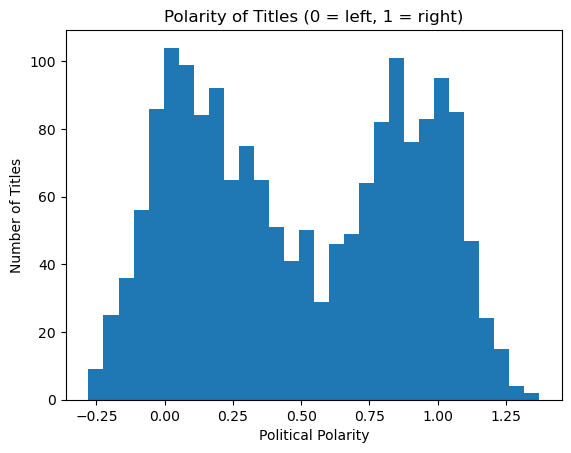

In [26]:
glove_test_distribution = glove_model.predict(X_test)

plt.hist(glove_test_distribution,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

500/500 [==============================] - 2s 3ms/step


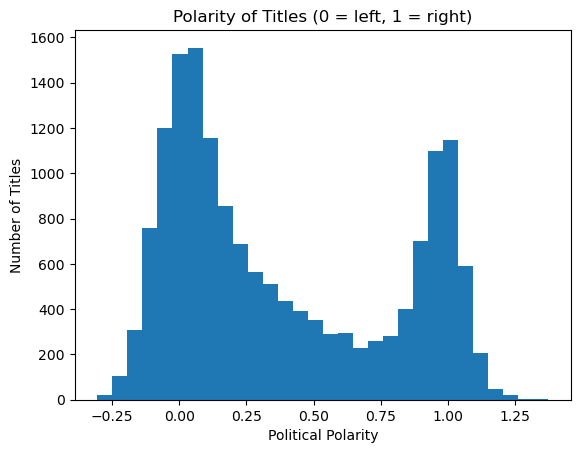

In [43]:
glove_neutral_dist = glove_model.predict(test_padded)
plt.hist(glove_neutral_dist,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

55/55 [==============================] - 0s 3ms/step


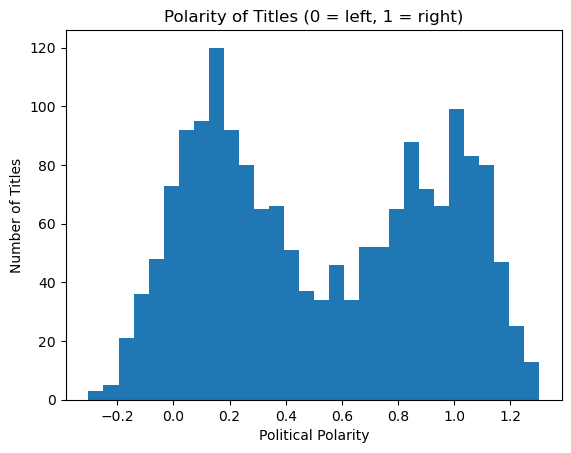

In [44]:
numberbatch_test_distribution = numberbatch_model.predict(X_test)

plt.hist(numberbatch_test_distribution,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

500/500 [==============================] - 2s 3ms/step


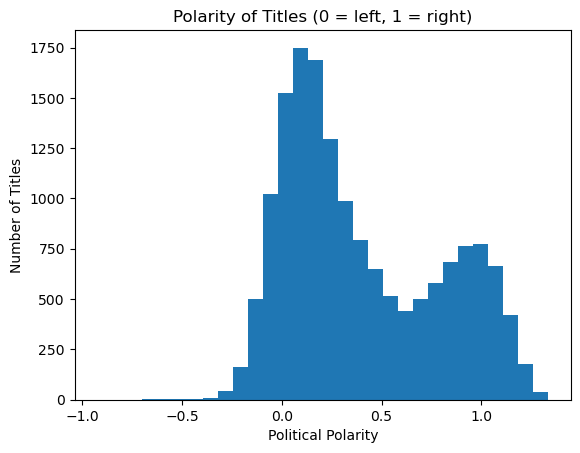

In [36]:
numberbatch_neutral_dist = numberbatch_model.predict(test_padded)
plt.hist(numberbatch_neutral_dist,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

In [30]:
# print the mean of the distributions for the test set
print("Test set:")
print("Numberbatch mean: " + str(numberbatch_test_distribution.mean()))
print("Glove mean: " + str(glove_test_distribution.mean()))
print()

# print the mean of the distributions for the neutral samples
print("Neutral samples:")
print("Numberbatch mean: " + str(numberbatch_neutral_dist.mean()))
print("Glove mean: " + str(glove_neutral_dist.mean()))

Test set:
Numberbatch mean: 0.5263879
Glove mean: 0.49714702
Neutral samples:
Numberbatch mean: 0.40003216
Glove mean: 0.38757804


In [39]:
numberbatch_neutral_dist == glove_neutral_dist

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [46]:
labeled_expert = pd.read_csv('data/expert_neutral_headlines.csv')

titles = labeled_expert['title'].astype(str).values

seq = tokenizer.texts_to_sequences(test)
expert_padded = pad_sequences(seq, maxlen=MAX_TITLE_LEN)

500/500 [==============================] - 2s 4ms/step


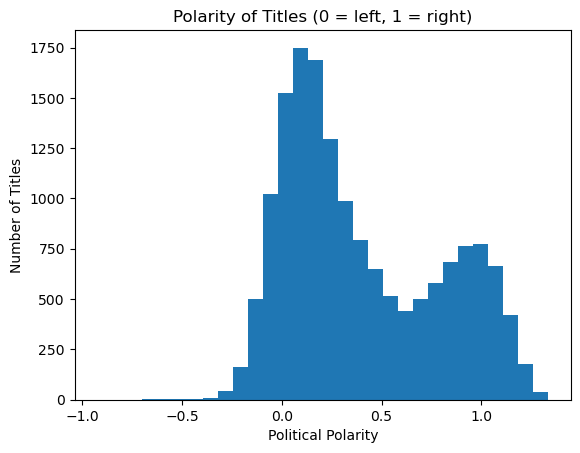

In [45]:
numberbatch_expert_neutral = numberbatch_model.predict(expert_padded)
plt.hist(numberbatch_expert_neutral,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

500/500 [==============================] - 2s 3ms/step


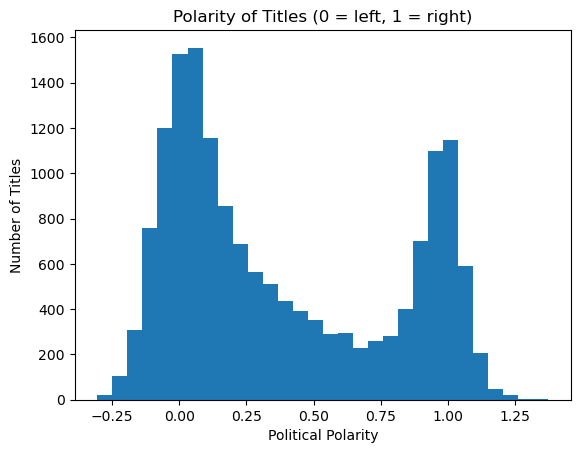

In [37]:
glove_expert_neutral = glove_model.predict(expert_padded)
plt.hist(glove_expert_neutral,30)
plt.xlabel('Political Polarity')
plt.ylabel('Number of Titles')
plt.title('Polarity of Titles (0 = left, 1 = right)')
plt.show()

In [38]:
print("Numberbatch mean: " + str(numberbatch_expert_neutral.mean()))
print("Glove mean: " + str(glove_expert_neutral.mean()))

Numberbatch mean: 0.40003216
Glove mean: 0.38757804
